<a id='toc'></a>

<div class="alert alert-block alert-info">
<center> <h1> Enterprise Data Science Bootcamp </h1> </center> <br>
<center> <h2> Inventory Management- Back Orders </h2> </center>
<center> <h3>   2021/2022 </h3> </center>

**GROUP E:** <br>
- Nuno Bolas          `20211052` <br>
- João Magalhães      `20211044` <br>
- Mariana Teixeira    `20211058` <br>
- Maria Trindade      `20211049` <br>

https://medium.com/analytics-vidhya/predicting-material-backorders-in-inventory-management-90e4d0ece6ba



## Table of Contents

* [Import](#chapter0)
* [Data Understanding](#chapter1)
* [Data preparation](#chapter2)
* [Feature Engineering](#chapter3)
* [Feature Selection](#chapter4)
* [Train Test Split](#chapter7)
* [Balancing the dataset](#chapter8)
* [Modelling](#chapter5)
    * [K-Folds and Repeated K-Folds](#chapter5.1)
    * [Logistic Regression](#chapter5.2)
    * [Neural Networks](#chapter5.3)
    * [Random Forest](#chapter5.4)
    * [Gradient Boosted Decision Tree](#chapter5.5)
    * [Adaboost](#chapter5.6)
    * [Extra Trees](#chapter5.7)
    * [Model Comparison](#chapter5.8)
* [Prediction](#chapter6)

[Back to the start](#toc)

## Import <a class="anchor" id="chapter0"></a>

In [1]:
#Data Understanding
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer

#Feature Engineering/Selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp
from scipy import stats

# Modelling 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Set the style for the Seaborn's plots
sns.set_style('whitegrid',{
    'xtick.bottom': False,
    'xtick.color': '.1',
    'xtick.direction': 'out',
    'xtick.top': False,
    'xtick.major.size': 1,
    'xtick.minor.size': 0.5,
    'ytick.left': True,
    'ytick.color': '.1',
    'ytick.direction': 'out',
    'ytick.right': False,
    'ytick.major.size': 1,
    'ytick.minor.size': 0.5,    
    'ytick.color': '.1',
    'grid.linestyle': '--',
    'axes.edgecolor': '.1',
    'grid.color': '0.8'
 })

palette = sns.color_palette("Set2") 
sns.set_palette(palette)

[Back to the start](#toc)

## Data Understanding <a class="anchor" id="chapter1"></a>

In [ ]:
test = pd.read_csv("data/Test_Dataset_v2.csv")
train = pd.read_csv("data/Training_Dataset_v2.csv")

In [ ]:
train['perf_6_month_avg'].mean()

In [ ]:
train['perf_12_month_avg'].mean()

In [ ]:
test.head(5)

### Initial Analysis

In [ ]:
#train = train.set_index("sku")
#test = test.set_index("sku")

In [ ]:
# descriptive statistics for the variables
train.describe()

In [ ]:
train.describe(include=['O'])

In [ ]:
train.info()

In [ ]:
# Duplicated records
print('Train: \n',train.duplicated().value_counts(),'\n') 

In [ ]:
# Missing Values on train dataset
train.isna().sum()

lead_time - Transit time for product (if available)

    Sku is the identifier and therefore, the index; 

    Out of the other 21 features (excluding the class label went_on_backorder), 15 of them are numerical and 6 of them are categorical. 
    All the categorical features (potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy and rev_stop) have either Yes or No, so we will transform them to binary; 

    The numerical features include national_inv, lead_time, in_transit_qty, forecast_3_month, forecast_6_month, forecast_9_month, sales_1_month, sales_3_month, sales_6_month, sales_9_month, min_bank, pieces_past_due, perf_6_month_avg, perf_12_month_avg, local_bo_qty. 

    lead_time is the only feature with missing values.In addition, the last row of every feature has null values so will removed. 

### Pandas profiling

In [ ]:
#pip install pandas-profiling

In [ ]:
#profile = ProfileReport(train)
#profile  

In [ ]:
#profile.to_file("report.html")

* The target variable went_on_backorder is a categorical feature with two values "Yes" and "No".
* 99.33% belong to the class "Yes" and remaining 0.669% belong to the class "No"; dataset is highly imbalanced with majority and minority class ratio of approximately 148:1
* in_transit_qty has 1344662 (79.7%) zeros

Real numbers: 
* forecasts: ~65% is 0; very correlated within themselves and with sales; highly skewed; with outliers;
* in transit: skewed; with ~80% of 0s; small IQR; many outliers; 
* lead_time: has 6% of missing values; 
* local_bo_qty: skewed; 98.9% of 0 values; 
* min_bank: 52% 0s; 
* performance features 6,12 months: high correlation with themselves, ~7-8% of -99
* pieces_past_due: skewed, 98.5% 0s; 
* sales: skewed; lots of 0s ~40%; high correlation with each others; 

Booleans: 
* oe_constraint: 99% no (high relation with backorder); 
* potential_issue: 99.9% No(high relation with backorder);
* ppap_risk: -
* rev_stop: 99.9% no (no relation with backorder). 

[Back to the start](#toc)

## Data Preparation <a class="anchor" id="chapter2"></a>

### Missing values

In [ ]:
total = np.round(train['lead_time'].isna().sum()/ len(train), 4)
print('Total percentage of Missing Values: ', total*100, '%')

In [ ]:
train.drop(train[train['national_inv'].isna()].index,inplace = True) 
#This line was NA in all values but sku, so it was deleted

In [ ]:
train_numerical = train.select_dtypes(include='number')

In [ ]:
#imputer = KNNImputer(n_neighbors=2, weights="uniform").fit(train_numerical)
#imputed_matrix = imputer.transform(train_numerical)

In [ ]:
#data_cleaned = pd.DataFrame(data=imputed_matrix, columns=train_numerical.columns, index=train_numerical.index)

In [ ]:
#train[data_cleaned.columns] = data_cleaned

In [ ]:
#train.isna().sum()

In [ ]:
#IMPUTING WITH KNN TAKES WAY TOO MUCH TIME (1H+)? Don't know why

In [ ]:
train_numerical.mean()

In [ ]:
#train_numerical = train_numerical.fillna(train_numerical.mean())

In [ ]:
#imputer = KNNImputer(n_neighbors=2, weights="uniform").fit(train_numerical)
#imputed_matrix = imputer.transform(train_numerical)
#data_cleaned = pd.DataFrame(data=imputed_matrix, columns=train_numerical.columns, index=train_numerical.index)

In [ ]:
#train[data_cleaned.columns] = data_cleaned

In [ ]:
#train

In [ ]:
#train[train_numerical.columns] = train_numerical

In [ ]:
#train.to_csv('train_cleaned.csv')

In [ ]:
train = pd.read_csv('train_cleaned.csv')

In [ ]:
train.isna().sum()

### Duplicates

In [ ]:
#train.duplicated().sum() 0 duplicates without index as sku

In [ ]:
#train.duplicated().sum()/train.shape[0] 

There are no duplicates in this dataset

In [ ]:
train = train.set_index("sku")

In [ ]:
train.head()

### Outliers

In [ ]:
for i in train_numerical:
    sns.boxplot(data=train_numerical, x=i)
    plt.show()

In [ ]:
outlier_metric_features = train_numerical.columns

#### Outliers

In [ ]:
q25 = train.quantile(.25)
q75 = train.quantile(.75)
iqr = (q75 - q25)



upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr



filters2 = []
for metric in outlier_metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(train[metric].between(llim, ulim, inclusive=True))


filters2 = pd.Series(np.all(filters2, 0), index=train.index)
df_2 = train[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / train.shape[0], 4))

#### Z-score

In [ ]:
total = 0
for i in outlier_metric_features: 
    z = np.abs(stats.zscore(train[i])) 
    z[z > 3].count()
    print('Percentage of outliers for',str(i),' : ', (np.round((z[z > 3].count())/ len(train), 4)*100))
    total += (np.round((z[z > 3].count())/ len(train), 4))

print('Total percentage of Outliers: ', total*100, '%')

In [ ]:
train = train[(z < 3)]

In [ ]:
train.shape

### Transform Variables

**Dummies**

In [ ]:
train = pd.get_dummies(train, drop_first = True)

In [ ]:
train.columns

In [ ]:
train.rename(columns = {'went_on_backorder_Yes':'went_on_backorder'},inplace = True)

train = train.reindex(columns= ['went_on_backorder','national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes'])

In [ ]:
#train.rename(columns = {'potential_issue_Yes':'potential_issue', 'deck_risk_Yes':'deck_risk','oe_constraint_Yes':'oe_constraint',
#                       'ppap_risk_Yes':'ppap_risk','stop_auto_buy_Yes':'stop_auto_buy','rev_stop_Yes': 'rev_stop',
#                       'went_on_backorder_Yes': 'went_on_backorder'}, inplace = True)

#train = train.reindex(columns=['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
#       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
#       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
#       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
#       'local_bo_qty', 'potential_issue', 'deck_risk',
#       'oe_constraint', 'ppap_risk', 'stop_auto_buy',
#       'rev_stop', 'went_on_backorder'])
#train.head()

**Datatypes**

In [ ]:
#train = train.astype('float16')
#train.head(5)

### Standardize the dataset

In [ ]:
#feats = ['national_inv', 'lead_time','perf_6_month_avg', 'perf_12_month_avg']

In [ ]:
#scaler = StandardScaler().fit(train[feats])

In [ ]:
#train[feats] = scaler.transform(train[feats])

In [ ]:
#train.head(5)

[Back to the start](#toc)

## Feature Engineering <a class="anchor" id="chapter3"></a>

### Correlations

**Pearson**

In [ ]:
# Compute the correlation matrix - Pearson
corr = train.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask,cmap = 'YlGnBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})
pyplot.title('Pearson Correlation')
pyplot.show()

**Spearman**

In [ ]:
# Compute the correlation matrix - Spearman
corr = train.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask,cmap = 'YlGnBu', vmax = 1, vmin=-1, center = 0,
            square = True, annot = True, linewidths = .5, cbar_kws = {"shrink": .5})
pyplot.title('Spearman Correlation')
pyplot.show()

In [ ]:
corr_pairs = corr.unstack().sort_values(kind="quicksort")
abs(corr_pairs)[abs(corr_pairs).between(.65,.9999)]

In_transit_qty, forecast_3_month, forecast_6_month, forecast_9_month, sales_1_month, sales_3_month, sales_6_month, sales_9_month and min_bank are highly correlated with each other. Among them, forecast_3_month, forecast_6_month and forecast_9_month are more correlated with each other compared to the rest. Similarly, sales_1_month, sales_3_month, sales_6_month and sales_9_month are more correlated with each other than any other feature. We also see that perf_6_month_avg and perf_12_month_avg are highly correlated with each other.

**Kolmogorov–Smirnov test for numerical features**

In [ ]:
numerical_feats = ['national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty']

In [ ]:
#ks_2samp(pd.DataFrame(train['went_on_backorder']),train[numerical_feats]) #not working, try to figure the issue

**Stochastic/Probability Matrix for categorical features**

In [ ]:
train.columns

In [ ]:
categorical_feats = ['potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes']

In [ ]:
for i in categorical_feats: 
    cat_vs_went_on_backorder = train.loc[:, [i, 'went_on_backorder']]
    x = np.array(cat_vs_went_on_backorder)

    cat_matrix = np.array([[x[np.where((x[:,0] == 0) * (x[:,1] == 0))].shape[0] / len(x), 
                                                    x[np.where((x[:,0] == 0) * (x[:,1] == 1))].shape[0] / len(x)],
                                                   [x[np.where((x[:,0] == 1) * (x[:,1] == 0))].shape[0] / len(x), 
                                                    x[np.where((x[:,0] == 1) * (x[:,1] == 1))].shape[0] / len(x)]])

    cat_matrix_df = pd.DataFrame(cat_matrix, columns=['No', 'Yes'], index=['No', 'Yes'])
    print(cat_matrix_df)

### PCA

In [ ]:
x_train = train.drop('went_on_backorder', axis=1)
y_train = train['went_on_backorder']

standard_scalar = StandardScaler()
std_x_train = standard_scalar.fit_transform(x_train)

model = PCA(n_components=2, random_state=42)
pca_data = model.fit_transform(std_x_train)
pca_data = np.vstack((pca_data.T, y_train)).T
pca_df = pd.DataFrame(data=pca_data, columns=("pc1", "pc2", "went_on_backorder"))

sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'pc1', 'pc2').add_legend()
plt.title("PCA")
plt.show()

[Back to the start](#toc)

## Feature Selection <a class="anchor" id="chapter4"></a>

In [ ]:
train.columns

In [ ]:
#train['sales_agg'] = train[['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']].mean(axis =1)

In [ ]:
#train['forecast_agg'] = train[['forecast_3_month', 'forecast_6_month', 'forecast_9_month']].mean(axis =1)

In [ ]:
#train['perf_agg'] = train[['perf_6_month_avg', 'perf_12_month_avg']].mean(axis =1)

In [ ]:
train['sales_month'] = train['sales_9_month']/9
train['forecast_month'] = train['forecast_9_month']/9
train['perf_month'] = train['perf_6_month_avg']

In [ ]:
train.drop(columns = ['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month','forecast_3_month',
                      'forecast_6_month', 'forecast_9_month','perf_6_month_avg', 'perf_12_month_avg'],inplace = True)

In [ ]:
train[train['perf_month']==-99.00]['perf_month'].count()

In [ ]:
train['perf_month'] = train['perf_month'].replace(-99.00, np.nan)

In [ ]:
train.isna().sum()

### Filling in the missing values

In [ ]:
#train_numerical = train.select_dtypes(include='number')
#imputer = KNNImputer(n_neighbors=2, weights="uniform").fit(train_numerical)
#imputed_matrix = imputer.transform(train_numerical)

In [ ]:
#data_cleaned = pd.DataFrame(data=imputed_matrix, columns=train_numerical.columns, index=train_numerical.index)
#train[data_cleaned.columns] = data_cleaned

In [ ]:
#train.to_csv('train.csv')

In [3]:
train = pd.read_csv('train.csv')

[Back to the start](#toc)

## Train Test Split <a class="anchor" id="chapter7"></a>

In [4]:
X = train.drop('went_on_backorder', axis=1)
y = train['went_on_backorder']

In [5]:
# TRAIN (70%) & VALIDATION (30%) SPLIT
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

In [6]:
y_train.value_counts()

0.0    1172528
1.0       7848
Name: went_on_backorder, dtype: int64

In [7]:
train.columns

Index(['sku', 'went_on_backorder', 'national_inv', 'lead_time',
       'in_transit_qty', 'min_bank', 'pieces_past_due', 'local_bo_qty',
       'potential_issue_Yes', 'deck_risk_Yes', 'oe_constraint_Yes',
       'ppap_risk_Yes', 'stop_auto_buy_Yes', 'rev_stop_Yes', 'sales_month',
       'forecast_month', 'perf_month'],
      dtype='object')

In [8]:
feats = ['national_inv', 'lead_time','in_transit_qty', 'min_bank','pieces_past_due','local_bo_qty'
         ,'perf_month','forecast_month','sales_month']

scaler = StandardScaler()


#scaler.fit(y_train).transform(y_val)


X_train[feats] = scaler.fit(X_train[feats]).transform(X_train[feats])
X_val[feats] = scaler.fit(X_val[feats]).transform(X_val[feats])


#train.head(5)

[Back to the start](#toc)

## Balancing the dataset <a class="anchor" id="chapter8"></a>

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 
https://heartbeat.comet.ml/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa

### SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

In [21]:
oversample = SMOTE(sampling_strategy='minority')

In [22]:
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [23]:
counter = Counter(y_smote)
print(counter)

Counter({0.0: 1172528, 1.0: 1172528})


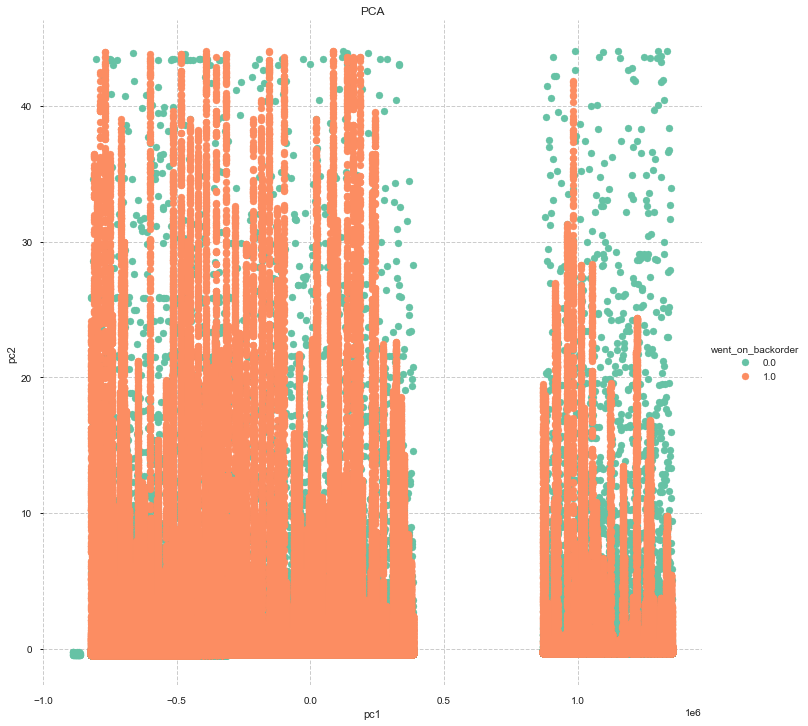

In [24]:
model = PCA(n_components=2, random_state=42)
pca_data = model.fit_transform(X_smote)
pca_data = np.vstack((pca_data.T, y_smote)).T
pca_df = pd.DataFrame(data=pca_data, columns=("pc1", "pc2", "went_on_backorder"))

sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'pc1', 'pc2').add_legend()
plt.title("PCA")
plt.show()

### SMOTE + TomekLinks

In [ ]:
#from imblearn.combine import SMOTEENN
#from imblearn.under_sampling import EditedNearestNeighbours 

In [ ]:
#resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
#x_train_tomek, y_train_tomek = resample.fit_resample(X_train, y_train)

In [ ]:
#print(Counter(y_train_tomek))

In [ ]:
#x_train_tomek.to_csv('x_tomek.csv')
#y_train_tomek.to_csv('y_tomek.csv')

#x_tomek = pd.read_csv('x_tomek.csv',index_col = False).drop(columns=['Unnamed: 0'])
#y_tomek = pd.read_csv('y_tomek.csv',index_col = False).drop(columns=['Unnamed: 0'])#

In [ ]:
#model = PCA(n_components=2, random_state=42)
#pca_data = model.fit_transform(x_tomek)
#pca_data = np.vstack((pca_data.T, y_tomek)).T
#pca_df = pd.DataFrame(data=pca_data, columns=("pc1", "pc2", "went_on_backorder"))

#sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'pc1', 'pc2').add_legend()
#plt.title("PCA")
#plt.show()

### ADASYN

In [32]:
from imblearn.over_sampling import ADASYN

# create the object to resample the majority class.
adasyn = ADASYN(sampling_strategy="minority")

# fit the object to the training data.
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

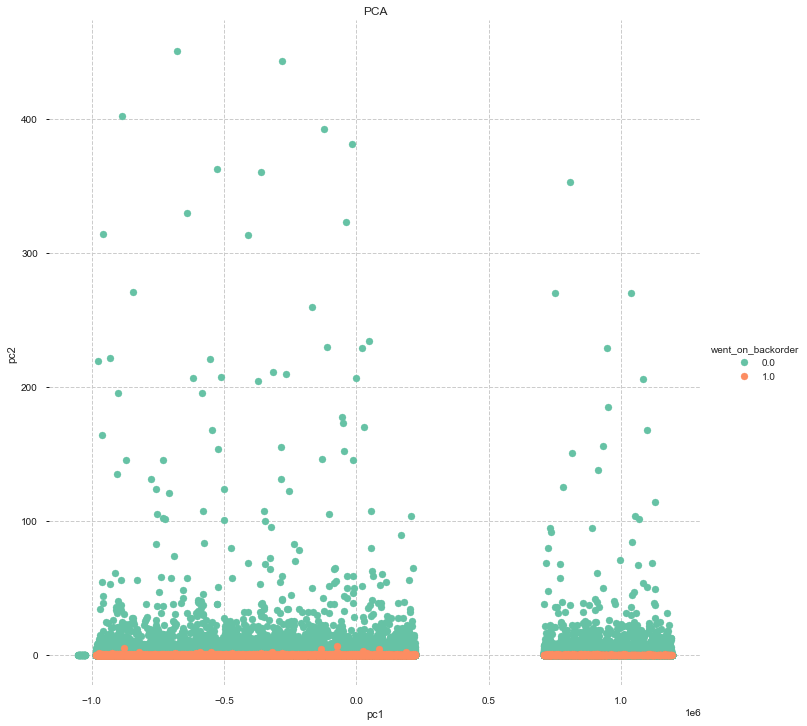

In [33]:
model = PCA(n_components=2, random_state=42)
pca_data = model.fit_transform(X_train)
pca_data = np.vstack((pca_data.T, y_train)).T
pca_df = pd.DataFrame(data=pca_data, columns=("pc1", "pc2", "went_on_backorder"))

sns.FacetGrid(pca_df, hue='went_on_backorder', height=10).map(plt.scatter, 'pc1', 'pc2').add_legend()
plt.title("PCA")
plt.show()

[Back to the start](#toc)

## Modelling <a class="anchor" id="chapter5"></a>

### K-Folds and Repeated K-folds  <a class="anchor" id="chapter5.1"></a>

In [34]:
kf = KFold(n_splits=10)
rkf = RepeatedKFold(n_splits=10, n_repeats=2) 

In [35]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 168626  168627  168628 ... 1686249 1686250 1686251] TEST: [     0      1      2 ... 168623 168624 168625]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [168626 168627 168628 ... 337249 337250 337251]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [337252 337253 337254 ... 505874 505875 505876]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [505877 505878 505879 ... 674499 674500 674501]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [674502 674503 674504 ... 843124 843125 843126]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [ 843127  843128  843129 ... 1011749 1011750 1011751]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [1011752 1011753 1011754 ... 1180374 1180375 1180376]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [1180377 1180378 1180379 ... 1348999 1349000 1349001]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] T

In [36]:
for train_index, test_index in rkf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [     12      17      19 ... 1686239 1686242 1686248]
TRAIN: [      0       1       2 ... 1686248 1686249 1686251] TEST: [      4      37      73 ... 1686241 1686245 1686250]
TRAIN: [      1       2       3 ... 1686249 1686250 1686251] TEST: [      0       9      10 ... 1686224 1686227 1686244]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [      3       5       7 ... 1686180 1686182 1686214]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [     26      36      59 ... 1686225 1686229 1686234]
TRAIN: [      0       1       2 ... 1686249 1686250 1686251] TEST: [     13      14      22 ... 1686221 1686223 1686247]
TRAIN: [      0       2       3 ... 1686249 1686250 1686251] TEST: [      1      11      25 ... 1686213 1686232 1686237]
TRAIN: [      0       1       2 ... 1686248 1686249 1686250] TEST: [      6       8      21 ... 1686235 1686246 1686251]
TRAIN: [      0       1       2 

### Important functions

In [37]:
def avg_score(method,model):
    # apply kfold
    kf = method
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [38]:
def mlp_avg_score(method, model):
    # apply kfold
    kf = method #K-folds: takes our entire dataset and divides it 10 times
    # create lists to store the results from the different models 
    score_train = []
    score_val = []
    timer = []
    n_iter = []
    for train_index, val_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train) #we are checking both scores, value_train and value_val to make sure that it doesn't overfit 
        # check the mean accuracy for the validation #we don't want our model to be very good in the train data, but not in test
        value_val = model.score(X_val, y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_val.append(value_val)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_val) + '+/-' + str(std_val), str(avg_iter) + '+/-' + str(std_iter)

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [40]:
def report(y_train, y_pred):
    print('                                        Classification Report                                            ')
    print('-------------------------------------------------------------------------------------------------------\n')
    print(classification_report(y_train, y_pred))
    
    print('\n                                        Confusion Matrix                                               ')
    print('-------------------------------------------------------------------------------------------------------\n')
    print(confusion_matrix(y_train,y_pred))

### Logistic Regression  <a class="anchor" id="chapter5.2"></a>

**smote**

In [41]:
lr_model = LogisticRegression().fit(X_smote, y_smote)

In [45]:
y_pred = lr_model.predict(X_val)

In [46]:
#avg_score(kf,lr_model)

In [48]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    502513
         1.0       0.00      0.00      0.00      3363

    accuracy                           0.99    505876
   macro avg       0.50      0.50      0.50    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[502513      0]
 [  3363      0]]


**adasyn**

In [49]:
lr_model = LogisticRegression().fit(x_train_adasyn, y_train_adasyn)

In [50]:
y_pred = lr_model.predict(X_val)

In [51]:
y_pred = lr_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    502513
         1.0       0.00      0.00      0.00      3363

    accuracy                           0.99    505876
   macro avg       0.50      0.50      0.50    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[502513      0]
 [  3363      0]]


### Neural Networks  <a class="anchor" id="chapter5.3"></a>

In [52]:
param_grid = {
    'hidden_layer_sizes': [(10,10), (10,10,10)],
     'alpha': [0.0001, 0.001],
     'learning_rate': ['adaptive', 'invscaling']
}

In [53]:
#nn_search = GridSearchCV(MLPClassifier(), param_grid, cv=3,scoring='f1').fit(X_train, y_train) #cv = cross validation

In [54]:
#nn_search.best_params_

**smote**

In [55]:
nn_model = MLPClassifier(alpha= 0.0001,hidden_layer_sizes= (10, 10),learning_rate= 'adaptive').fit(X_smote, y_smote)

In [56]:
y_pred = nn_model.predict(X_val)

In [57]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    502513
         1.0       0.00      0.00      0.00      3363

    accuracy                           0.99    505876
   macro avg       0.50      0.50      0.50    505876
weighted avg       0.99      0.99      0.99    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[502513      0]
 [  3363      0]]


**adasyn**

In [58]:
nn_model = MLPClassifier(alpha= 0.0001,hidden_layer_sizes= (10, 10),learning_rate= 'adaptive').fit(x_train_adasyn, y_train_adasyn)

In [59]:
y_pred = nn_model.predict(X_val)

In [60]:
y_pred = nn_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    502513
         1.0       0.01      1.00      0.01      3363

    accuracy                           0.01    505876
   macro avg       0.00      0.50      0.01    505876
weighted avg       0.00      0.01      0.00    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[     0 502513]
 [     0   3363]]


### Random Forest <a class="anchor" id="chapter5.4"></a>

**smote**

In [61]:
rf_model = RandomForestClassifier(max_depth= 15, n_estimators= 50).fit(X_smote, y_smote)

In [62]:
y_pred = rf_model.predict(X_val)

In [63]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.13      0.23    502513
         1.0       0.01      0.98      0.01      3363

    accuracy                           0.13    505876
   macro avg       0.50      0.56      0.12    505876
weighted avg       0.99      0.13      0.22    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[ 64115 438398]
 [    53   3310]]


**adasyn**

In [64]:
rf_model = RandomForestClassifier(max_depth= 15, n_estimators= 50).fit(x_train_adasyn, y_train_adasyn)

In [65]:
y_pred = rf_model.predict(X_val)

In [66]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.11      0.20    502513
         1.0       0.01      0.99      0.01      3363

    accuracy                           0.11    505876
   macro avg       0.50      0.55      0.11    505876
weighted avg       0.99      0.11      0.20    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[ 54684 447829]
 [    42   3321]]


### Gradient Boosted Decision Tree  <a class="anchor" id="chapter5.5"></a>

**smote**

In [67]:
gb_model = GradientBoostingClassifier(max_depth=20, n_estimators=30).fit(X_smote, y_smote)

In [68]:
y_pred = gb_model.predict(X_val)

In [69]:
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.33      0.49    502513
         1.0       0.01      0.81      0.02      3363

    accuracy                           0.33    505876
   macro avg       0.50      0.57      0.25    505876
weighted avg       0.99      0.33      0.49    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[164517 337996]
 [   644   2719]]


**adasyn**

In [70]:
gb_model = GradientBoostingClassifier(max_depth=20, n_estimators=30).fit(x_train_adasyn, y_train_adasyn)

In [72]:
y_pred = gb_model.predict(X_val)

In [73]:
y_pred = gb_model.predict(X_val)
report(y_val,y_pred)

                                        Classification Report                                            
-------------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

         0.0       1.00      0.21      0.34    502513
         1.0       0.01      0.89      0.01      3363

    accuracy                           0.21    505876
   macro avg       0.50      0.55      0.18    505876
weighted avg       0.99      0.21      0.34    505876


                                        Confusion Matrix                                               
-------------------------------------------------------------------------------------------------------

[[103021 399492]
 [   378   2985]]
